In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.tsa.ts_utils import * 
from scripts.python.tsa.utsmodel import * 
from scripts.python.tsa.mtsmodel import * 
from scripts.python.tsa.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

## SARMIAX
### Single-best

,date,australia,new_zealand,new_caledonia,other_pic,europe,north_america,japan,china,other_countries,total,fileyear,not_stated,stringency_index,covid,vanuatu_flights,vanuatu_hotel,vanuatu_travel
0,2003-12-01,2938.0,580.0,646.0,136.0,201.0,88.0,42.0,0.0,103.0,4734.0,2007.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2004-01-01,2864.0,439.0,717.0,122.0,186.0,67.0,36.0,0.0,61.0,4492.0,2005.0,0.0,0.0,0.0,2.232933,3.102047,2.453441
2,2004-02-01,2158.0,194.0,416.0,282.0,229.0,82.0,34.0,0.0,93.0,3488.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,2004-03-01,2733.0,420.0,255.0,160.0,195.0,115.0,53.0,0.0,83.0,4014.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2004-04-01,2377.0,438.0,469.0,206.0,225.0,115.0,45.0,0.0,80.0,3955.0,2005.0,0.0,0.0,0.0,0.000000,0.000000,1.694580


training size : 224, testing size : 0
THE BENCHMARK EVALUATION FOR VANUATU 

STARTED TO CONDUCT STEPWISE SEARCHING FOR VANUATU 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  224
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -278.286
Date:                            Wed, 24 May 2023   AIC                            572.571
Time:                                    18:15:12   BIC                            599.829
Sample:                                         0   HQIC                           583.575
                                            - 224                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

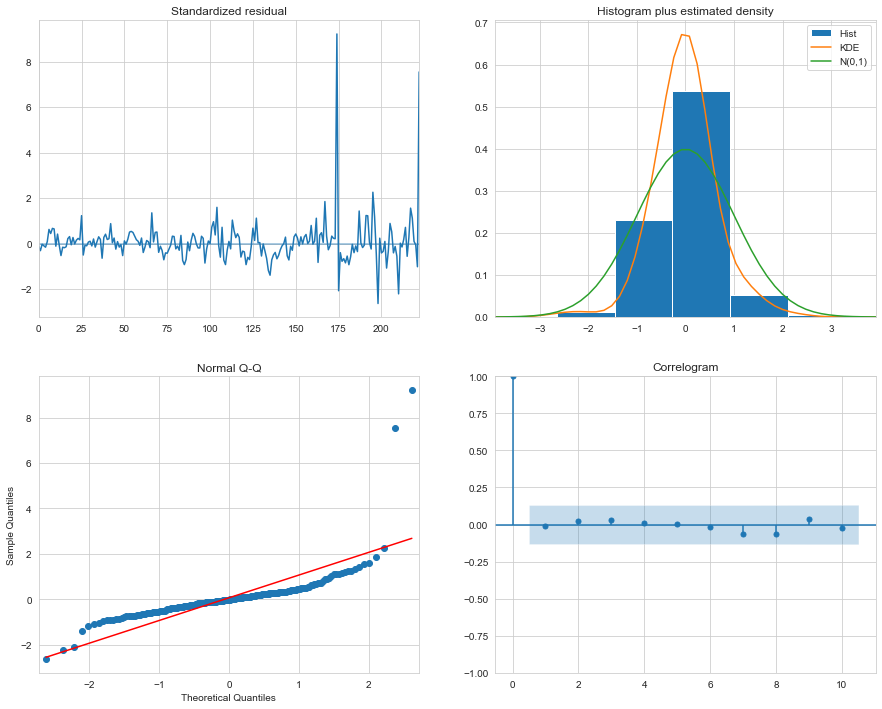

STARTED TO CONDUCT GRID SEARCHING FOR VANUATU 

STARTED TO CONDUCT CROSS-VALIDATION FOR VANUATU 

Best Models from Cross-validation is  ARIMA(1,0,1)(2,1,2)[12] intercept 



,MSE,RMSE,MAE,SMAPE
naive,2.915180e+06,1707.389827,1292.829596,20.537447
mean,1.125218e+07,3354.426412,2628.520727,47.767194
seasonal naive,8.396013e+06,2897.587484,1568.424107,34.617696
SARIMAX,1.238855e+06,1113.038657,795.607455,35.718702


In [2]:
countries = ["vanuatu"]
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

for country in countries:

    mod = SARIMAXPipeline(country=country, y_var="total",
                          data=None,
                          exog_var=["covid", "stringency_index",
                                    str(country)+"_travel"],
                          transform_method="scaledlogit",
                          training_ratio=1,
                          verbose=False)
    mod.read_and_merge()
    display(mod.data.head(5))
    
    
    mod.transform()
    print(f"The Benchmark Evaluation for {country}".upper(), "\n")
    mod.get_benchmark_evaluation()
    print(f"Started to conduct stepwise searching for {country}".upper(), "\n")
    mod.stepwise_search()

    print(f"Started to conduct Grid searching for {country}".upper(), "\n")
    mod_msres = mod.manual_search(params=all_param)
    mod_msres.sort(key=lambda x: x[1])

    mod_swm = mod.stepwise_model
    if mod_msres[0][-1] == (mod_swm["order"], mod_swm["seasonal_order"]):
        print(mod_msres[0][-1])
    else:
        cv_models = []
        cv_models.append(pm.ARIMA(
            mod_swm["order"], mod_swm["seasonal_order"],  exog=mod.exog[:mod.training_size]))

        # Append top five GridSearch results
        for res in mod_msres[:5]:
            order, seasonal_order = res[-1]
            model = pm.ARIMA(order, seasonal_order,
                             exog=mod.exog[:mod.training_size])
            cv_models.append(model)

        print(
            f"Started to conduct Cross-validation for {country}".upper(), "\n")
        mod_cv_comp = mod.compare_models(
            y=mod.transformed_y, exog=mod.exog, models=cv_models)
        best_cv_idx = np.argmin(mod_cv_comp["avg_error"])
        print(
            f"Best Models from Cross-validation is {cv_models[best_cv_idx]}", "\n")

        if best_cv_idx > 0:
            best_mod = mod_msres[best_cv_idx-1][0]
            best_mod_pred = mod.get_prediction_df(
                best_mod, mod.test_size, mod.exog[-mod.test_size:])
        
        lower = mod.data["total"].min() - 1
        upper = mod.data["total"].max() + 1
        for col_idx, col in enumerate(best_mod_pred.columns):
            for row_idx, _ in enumerate(best_mod_pred[col]):
                best_mod_pred.iloc[row_idx, col_idx] = mod.inverse_scaledlogit(
                    best_mod_pred.iloc[row_idx, col_idx], upper, lower)

        # Merge the prediction with actual values
        best_mod_pred.columns.name = None
        best_mod_pred = pd.concat(
            [mod.data[["date", "total"]], best_mod_pred], axis=1)

        if mod.test_size != 0:
            pred_series = (best_mod_pred["train_pred"].fillna(0)
                           + best_mod_pred["test_pred"].fillna(0))
        else:
            pred_series = best_mod_pred["train_pred"]
        
        mod_eval = (pd.DataFrame(calculate_evaluation(
            best_mod_pred["total"], pred_series), index=["SARIMAX"]))
        mod_eval = pd.concat([mod.benchmark, mod_eval], axis=0)
        display(mod_eval)

### Ensemble

In [40]:
performance = pd.DataFrame()
for num in range(1, 100):
    ensemble = pd.DataFrame()
    for res in mod_msres[:num]:
        smod = res[0]
        smod_pred = mod.get_prediction_df(
            smod, mod.test_size, mod.exog[-mod.test_size:])

        lower = mod.data["total"].min() - 1
        upper = mod.data["total"].max() + 1
        for col_idx, col in enumerate(smod_pred.columns):
            for row_idx, _ in enumerate(smod_pred[col]):
                smod_pred.iloc[row_idx, col_idx] = mod.inverse_scaledlogit(
                    smod_pred.iloc[row_idx, col_idx], upper, lower)

        smod_pred.columns.name = None
        pred = (smod_pred[["train_pred"]]
                .rename({"train_pred": str(res[-1])}, axis=1))
        if len(ensemble) == 0:
            ensemble = pred
        else:
            ensemble = pd.concat([ensemble, pred], axis=1)

    ensemble["mean"] = ensemble.mean(axis=1)
    ensemble["data"] = mod.data["date"]
    ensemble["total"] = mod.data["total"]

    eval_df = (pd.DataFrame(calculate_evaluation(ensemble["total"], ensemble["mean"]),
                            index=[num]))
    if len(performance) == 0:
        performance = pd.DataFrame(eval_df)
    else:
        performance = pd.concat([performance, eval_df], axis=0)

93

### No-Scaled

training size : 211, testing size : 12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3651.310, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3729.387, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3569.384, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3635.303, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3727.389, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3723.062, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3552.534, Time=0.60 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3561.202, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3551.046, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3640.561, Time=0.17 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3553.008, Time=0.89 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3591.490, Time=0.71 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3574.633,

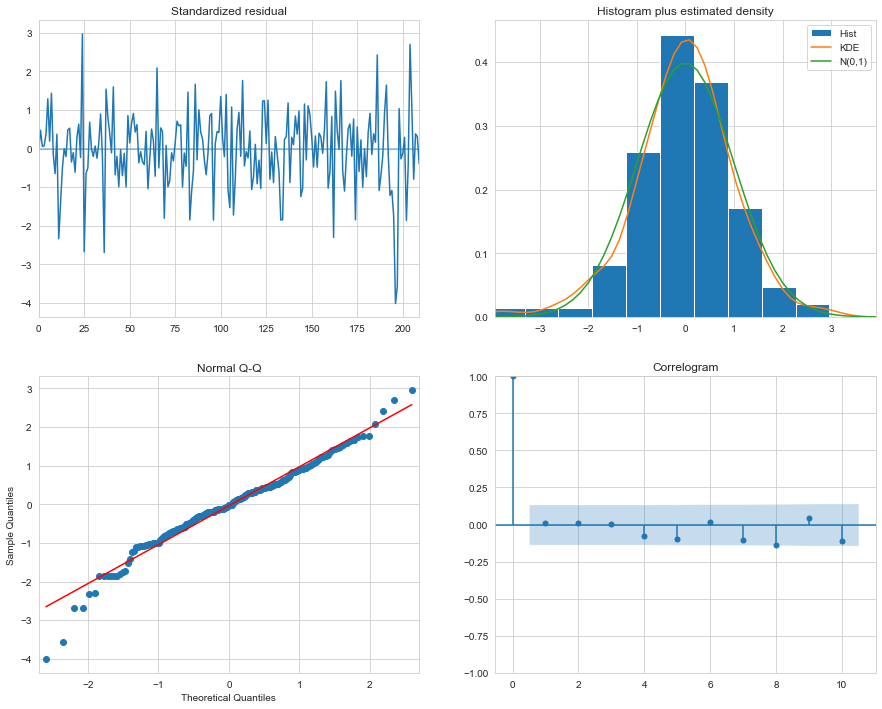

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:3408.59
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:3367.51
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:3366.71
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:3381.83
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:3364.85
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:3368.0
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:3377.9
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:3366.4
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:3369.86
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:3378.58
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:3339.05
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:3340.45
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:3347.6
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:3340.18
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:3344.44
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:3344.99
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:3342.38
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:3346.76
Tried out SARI

In [15]:
vo = SARIMAXPipeline(data=vu, y_var="Total", exog_var=["covid", "vanuatu_travel"],
                     transform_method=None, training_ratio=0.95)
vo.transform()
vo.stepwise_search()
vo_msres = vo.manual_search(all_param)

In [16]:
vo_msres.sort(key=lambda x: x[1])
vo_models = []
vo_sw = vo.stepwise_model
vo_models.append(pm.ARIMA(
    vo_sw["order"], vo_sw["seasonal_order"],  exog=vo.exog[:vo.training_size]))


for res in vo_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=vo.exog[:vo.training_size])
    vo_models.append(model)

In [17]:
for mod in vo_models:
    model_cv_scores = model_selection.cross_val_score(
        mod, vo.transformed_y[:vo.training_size], vo.exog[:vo.training_size], scoring="smape", verbose=2)
    model_avg_error = np.average(model_cv_scores)
    print(model_avg_error)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=116 ........................................................
[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] fold=121 ........................................................
[CV] fold=122 ........................................................
[CV] fold=123 ........................................................
[CV] fold=124 ........................................................
[CV] fold=125 ........................................................
[CV] fold=126 ........................................................
[CV] fold=127 ........................................................
[CV] fold=128 ........................................................
[CV] fold=129 ........................................................
[CV] f

[CV] fold=91 .........................................................
[CV] fold=92 .........................................................
[CV] fold=93 .........................................................
[CV] fold=94 .........................................................
[CV] fold=95 .........................................................
[CV] fold=96 .........................................................
[CV] fold=97 .........................................................
[CV] fold=98 .........................................................
[CV] fold=99 .........................................................
[CV] fold=100 ........................................................
[CV] fold=101 ........................................................
[CV] fold=102 ........................................................
[CV] fold=103 ........................................................
[CV] fold=104 ........................................................
[CV] f

[CV] fold=66 .........................................................
[CV] fold=67 .........................................................
[CV] fold=68 .........................................................
[CV] fold=69 .........................................................
[CV] fold=70 .........................................................
[CV] fold=71 .........................................................
[CV] fold=72 .........................................................
[CV] fold=73 .........................................................
[CV] fold=74 .........................................................
[CV] fold=75 .........................................................
[CV] fold=76 .........................................................
[CV] fold=77 .........................................................
[CV] fold=78 .........................................................
[CV] fold=79 .........................................................
[CV] f

[CV] fold=41 .........................................................
[CV] fold=42 .........................................................
[CV] fold=43 .........................................................
[CV] fold=44 .........................................................
[CV] fold=45 .........................................................
[CV] fold=46 .........................................................
[CV] fold=47 .........................................................
[CV] fold=48 .........................................................
[CV] fold=49 .........................................................
[CV] fold=50 .........................................................
[CV] fold=51 .........................................................
[CV] fold=52 .........................................................
[CV] fold=53 .........................................................
[CV] fold=54 .........................................................
[CV] f

[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................
[CV] f

[CV] fold=132 ........................................................
[CV] fold=133 ........................................................
[CV] fold=134 ........................................................
[CV] fold=135 ........................................................
[CV] fold=136 ........................................................
[CV] fold=137 ........................................................
[CV] fold=138 ........................................................
[CV] fold=139 ........................................................
[CV] fold=140 ........................................................
31.112789146160605
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..............................................

[CV] fold=107 ........................................................
[CV] fold=108 ........................................................
[CV] fold=109 ........................................................
[CV] fold=110 ........................................................
[CV] fold=111 ........................................................
[CV] fold=112 ........................................................
[CV] fold=113 ........................................................
[CV] fold=114 ........................................................
[CV] fold=115 ........................................................
[CV] fold=116 ........................................................
[CV] fold=117 ........................................................
[CV] fold=118 ........................................................
[CV] fold=119 ........................................................
[CV] fold=120 ........................................................
[CV] f

In [18]:
best_original = vo_msres[1][0]
original_mod = vo.get_prediction_df(best_original, steps=vo.test_size, exog=vo.exog[-vo.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([vu[["date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2004-01-01,4492.0,-466.706762,1923.255964,-4236.219183,3302.805660,NaN
1,2004-02-01,3488.0,4143.683620,1612.137649,983.951889,7303.415351,NaN
2,2004-03-01,4014.0,3625.676049,1598.664270,492.351656,6759.000442,NaN
3,2004-04-01,3955.0,3601.577381,1597.772357,470.001106,6733.153656,NaN
4,2004-05-01,3792.0,3680.541782,1597.712498,549.082827,6812.000737,NaN


In [19]:
org_pred = original_mod["train_pred"].fillna(0) + original_mod["test_pred"].fillna(0)
org_eval = pd.DataFrame(calculate_evaluation(vu["Total"], org_pred), index=["original"])
org_eval

,MSE,RMSE,MAE,MAPE
original,1.546558e+06,1243.606901,888.323368,inf


## VAR

## Ratio


VANUATU's Official and Avaition Data.

 Create Loaded Factor for VANUATU:

 Regression VANUATU:
                            WLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.951
Model:                            WLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     91.83
Date:                Wed, 24 May 2023   Prob (F-statistic):           8.77e-20
Time:                        00:09:25   Log-Likelihood:                 51.937
No. Observations:                  41   AIC:                            -87.87
Df Residuals:                      33   BIC:                            -74.17
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.514218,9548.0,18568.0,0.588312,0.029328,0.528643,0.647980,0.422595,0.754029,10923.776403
1,2019-02-01,0.426535,5835.0,13680.0,0.572673,0.030753,0.510106,0.635239,0.405890,0.739455,7834.160478
2,2019-03-01,0.475565,7026.0,14774.0,0.599281,0.028877,0.540530,0.658033,0.433893,0.764670,8853.783974
3,2019-04-01,0.553277,9445.0,17071.0,0.637386,0.030901,0.574518,0.700254,0.470490,0.804281,10880.813055
4,2019-05-01,0.498628,8359.0,16764.0,0.609568,0.030275,0.547974,0.671163,0.443148,0.775988,10218.804304


,MSE,RMSE,MAE,SMAPE
mean,2.273834e+07,4768.473803,4264.861006,156.566459
naive,2.446383e+06,1564.091833,808.452381,45.153360
ratio,6.686460e+05,817.707761,520.156920,128.001919


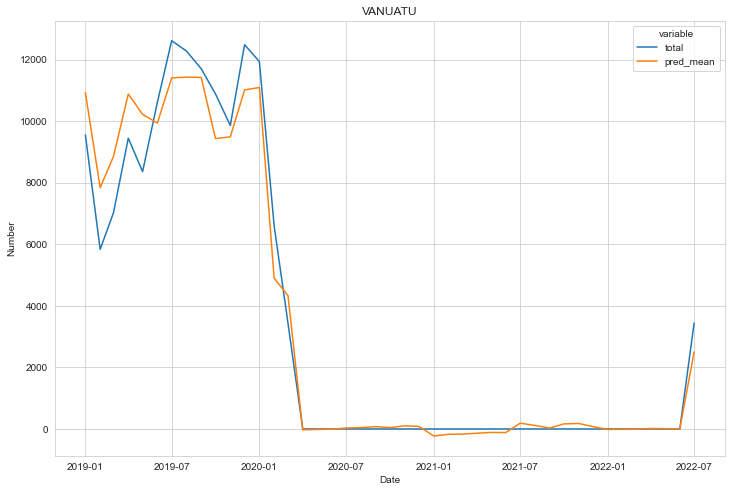

In [11]:
for country in ["vanuatu"]:
    
    mod = RatioPipe(country=country, data=None)
    print(f"\n{country.upper()}'s Official and Avaition Data.")
    mod.read_and_merge()
    
    print(f"\n Create Loaded Factor for {country.upper()}:")
    mod.transform()
    
    print(f"\n Regression {country.upper()}:")
    mod.fit()
    pred_df = mod.get_prediction_df()

    mean_pred, naive_pred = \
        mean_method(pred_df["total"]), naive_method(pred_df["total"])
    
    benchmark = pd.DataFrame()
    eval_name = ["mean", "naive", "ratio"]
    for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
        eval_df = pd.DataFrame(calculate_evaluation(pred_df["total"], pred), index=[idx])
        benchmark = pd.concat([benchmark, eval_df])
    display(benchmark)

    ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
    ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
    plt.show()
    